<a href="https://colab.research.google.com/github/Vigneshthanga/Diabetic_Retinopathy/blob/master/Project_DL_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Early detection of Diabetic Retinopathy using transfer learning [InceptionV3]

Team Members:

- Sivaranjani Kumar
- Vignesh Kumar Thangarajan
- Pooja Patil

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
ls '/content/gdrive/My Drive/Deep_Learning/eye_images/'

eye_image_2.png            model_logs/                 train_images/
eye_image.png              model_logs_2/               vgg/
gaussian_color_224.h5      model_logs_vgg16_2/         vgg16/
gaussian_color.h5          model_ranjani_resnet50_v1/  vgg16_log_1/
gaussian_color_y_train.h5  model_ranjani_vgg16_v3/     vgg16_log_2/
log_resnet_v1/             only_resize.h5              vgg16_log_3/
log_resnet_v2/             Project_DL_VGG16.ipynb      vgg16_structure.png
model_bayesian_v2/         resnet/


###Loading the data from drive, the data has been pre processed and saved in a .H5 format already

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


['x_train', 'y_train']
x shape = (3662, 150528)
y shape = (3662,)
(224, 224, 3)
<class 'numpy.ndarray'>
label :  4


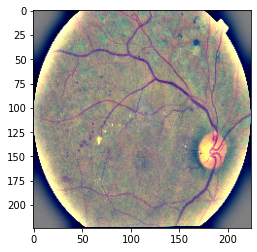

In [0]:
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
dest_file = '/content/gdrive/My Drive/Deep_Learning/eye_images/gaussian_color_224.h5'

with h5py.File(dest_file, "r") as f:
  print(list(f.keys()))
  x = f["x_train"][:]
  y = f["y_train"][:]
  print('x shape =', x.shape)
  print('y shape =', y.shape)

row = 5
image = x[row]
label = y[row]
image = (x[row]).reshape(224, 224, 3)
plt.imshow(image) 
print(image.shape)
print(type(image))
print("label : ", label)

###Reshaping the image data

In [0]:
import numpy as np
import pandas as pd
x= np.reshape(x,(3662,224,224,3))

In [0]:
np.unique(y)

array([0, 1, 2, 3, 4], dtype=int8)

In [0]:
x.shape

(3662, 224, 224, 3)

###Splitting the image data into Train, Test and Validation dataset

In [0]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.20, random_state=42)

#x_train, x_valid, y_train, y_valid = train_test_split(x_train_full, y_train_full, test_size=0.20, random_state=42)

In [0]:
x_train.shape

(2929, 224, 224, 3)

In [0]:
y_train.shape

(2929,)

In [0]:
x_valid.shape

(733, 224, 224, 3)

In [0]:
y_valid.shape

(733,)

###Import required modules

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocessor
from tensorflow.keras.layers import Input
from keras.models import Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Activation, Input, BatchNormalization
from keras import regularizers
from keras.initializers import he_uniform
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix, classification_report
%matplotlib inline

Using TensorFlow backend.


###Evaluation functions

In [0]:
def calculate_accuracy(Y_pred, Y_true):
    return accuracy_score(y_true= Y_true.reshape(-1), y_pred=Y_pred.reshape(-1))

In [0]:
def calculate_confusion_matrix(Y_pred, Y_true, labels):
    return  confusion_matrix(y_true=Y_true.reshape(-1), y_pred=Y_pred.reshape(-1), labels=labels)

In [0]:
def calculate_classification_report(Y_pred, Y_true, labels):
    return classification_report(y_true=Y_true.reshape(-1), y_pred=Y_pred.reshape(-1),labels=labels)

In [0]:
def evaluate_model(Y_pred, Y_true, labels=[0, 1, 2, 3, 4]):
  print("Accuracy: "+ str(calculate_accuracy(Y_pred.reshape(-1), Y_true.reshape(-1))))
  print(calculate_confusion_matrix(Y_pred.reshape(-1), Y_true.reshape(-1), labels))
  print(calculate_classification_report(Y_pred.reshape(-1), Y_true.reshape(-1), labels))

In [0]:
train_generator = ImageDataGenerator(
    preprocessing_function=inception_v3_preprocessor,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [0]:
train_generator.fit(x_train)

In [0]:
test_generator = ImageDataGenerator(
    preprocessing_function=inception_v3_preprocessor,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [0]:
test_generator.fit(x_valid)

In [0]:
input_tensor = Input(shape=(224, 224, 3))

In [0]:
def createInceptionV3():
    model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=True)
    
    for layer in model.layers:
        layer.trainable = False
        
    output_layer = model.get_layer("avg_pool").output
    
    return Model(inputs=model.input, outputs=output_layer)




#model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=True)

In [0]:
def create_model(reg=0):
    
    inception_v3_model= createInceptionV3()
    
    X_input = Input(shape=(2048,))
    dense1 = Dense(120,
                    kernel_initializer=he_uniform(seed=1),
                    bias_initializer='zeros', 
                    kernel_regularizer=regularizers.l2(reg), name="Dense1")(X_input)
    dense1 = BatchNormalization() (dense1)
    dense1 = Activation(activation="relu") (dense1)
    
    dense2 = Dense(60,
                    kernel_initializer=he_uniform(seed=1),
                    bias_initializer='zeros', 
                    kernel_regularizer=regularizers.l2(reg), name="dense2")(dense1)
    dense2 = BatchNormalization() (dense2)
    dense2 = Activation(activation="relu") (dense2)
    
    op1 = Dense(5, activation='softmax', name="outputs", 
                   kernel_regularizer=regularizers.l2(reg), 
                   kernel_initializer=he_uniform(seed=1), 
                   bias_initializer='zeros')(dense2)
    return (inception_v3_model, Model(input=X_input, output=op1))

In [0]:
adam = Adam(lr=0.001)
number_of_training_images = y_train.shape[0]
number_of_testing_images = y_valid.shape[0]

In [0]:
batch_size=32
#image_size=(299, 299)

In [0]:
model = create_model(reg=0)

96116736/96112376 [==============================] - 1s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


###Summary of InceptionV3 Base Model

In [0]:
model[0].summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

###Compiling InceptionV3 BaseModel 

In [0]:
model[0].compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [0]:
x_train = model[0].predict_generator(generator=train_generator.flow(x_train, y_train), steps=math.ceil(number_of_training_images / batch_size), verbose=1)
#y_train = y_train.reshape([-1, 1])
print("Shape of Y train: " + str(y_train.shape))
print("Shape of X train: " + str(x_train.shape))
x_valid = model[0].predict_generator(generator=test_generator.flow(x_valid, y_valid), steps=math.ceil(number_of_testing_images / batch_size), verbose=1)
#y_valid = y_valid.reshape([-1, 1])
print("Shape of Y test: " + str(y_valid.shape))
print("Shape of X test: " + str(x_valid.shape))

92/92 [==============================] - 38s 408ms/step
Shape of Y train: (2929,)
Shape of X train: (2929, 2048)
23/23 [==============================] - 9s 374ms/step
Shape of Y test: (733,)
Shape of X test: (733, 2048)


###Model 1 from Base Model

In [0]:
model[1].summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
Dense1 (Dense)               (None, 120)               245880    
_________________________________________________________________
batch_normalization_95 (Batc (None, 120)               480       
_________________________________________________________________
activation_95 (Activation)   (None, 120)               0         
_________________________________________________________________
dense2 (Dense)               (None, 60)                7260      
_________________________________________________________________
batch_normalization_96 (Batc (None, 60)                240       
_________________________________________________________________
activation_96 (Activation)   (None, 60)                0   

###Recompiling 

In [0]:
model[1].compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

###Fitting Model

In [0]:
model[1].fit(x=x_train, y=y_train, batch_size=batch_size, epochs=100, verbose=1, validation_data=(x_valid, y_valid))

Train on 2929 samples, validate on 733 samples
Epoch 1/100
2929/2929 [==============================] - 1s 359us/step - loss: 1.5085 - accuracy: 0.3875 - val_loss: 3.6215 - val_accuracy: 0.4789
Epoch 2/100
2929/2929 [==============================] - 1s 193us/step - loss: 1.2945 - accuracy: 0.4831 - val_loss: 12.4822 - val_accuracy: 0.4789
Epoch 3/100
2929/2929 [==============================] - 1s 195us/step - loss: 1.2780 - accuracy: 0.4899 - val_loss: 15.6103 - val_accuracy: 0.4789
Epoch 4/100
2929/2929 [==============================] - 1s 197us/step - loss: 1.2646 - accuracy: 0.5015 - val_loss: 23.7660 - val_accuracy: 0.4789
Epoch 5/100
2929/2929 [==============================] - 1s 191us/step - loss: 1.2481 - accuracy: 0.5015 - val_loss: 38.9322 - val_accuracy: 0.4789
Epoch 6/100
2929/2929 [==============================] - 1s 186us/step - loss: 1.2439 - accuracy: 0.5022 - val_loss: 54.2057 - val_accuracy: 0.4789
Epoch 7/100
2929/2929 [==============================] - 1s 189us/

In [0]:
print(model[1].evaluate(x=x_train, y=y_train, batch_size=batch_size, verbose=1))

2929/2929 [==============================] - 0s 70us/step
[200.99017688755129, 0.053601913154125214]


In [0]:
print(model[1].evaluate(x=x_valid, y=y_valid, batch_size=batch_size, verbose=1))

733/733 [==============================] - 0s 74us/step
[999.6784773718612, 0.09276944398880005]


In [0]:
y_train_2 = tf.keras.utils.to_categorical(y_train, num_classes=5)

In [0]:
y_train_2[5]

array([0., 0., 0., 1., 0.], dtype=float32)

In [0]:
y_train_2.shape

(2929, 5)

In [0]:
y = np.argmax(y_train_2, axis=-1)

In [0]:
np.unique(y)

array([0, 1, 2, 3, 4])

In [0]:
y.shape

(2929,)

In [0]:

x_train.shape

(2929, 2048)

In [0]:
x_train

array([[0.        , 0.59441304, 0.7425328 , ..., 0.00614379, 0.66890424,
        0.865148  ],
       [0.        , 0.59197503, 0.7439186 , ..., 0.00746162, 0.6668036 ,
        0.8525722 ],
       [0.        , 0.5921934 , 0.7424246 , ..., 0.00666489, 0.66482484,
        0.8536406 ],
       ...,
       [0.        , 0.59345907, 0.74790263, ..., 0.00734922, 0.6686753 ,
        0.8631099 ],
       [0.        , 0.59373146, 0.7458836 , ..., 0.00630162, 0.671281  ,
        0.84675246],
       [0.        , 0.59181154, 0.7434591 , ..., 0.00679794, 0.6693207 ,
        0.8531233 ]], dtype=float32)

In [0]:
Y_train_prediction = model[1].predict(x=x_train, batch_size=batch_size, verbose=1)
Y_train_prediction = (Y_train_prediction >= 0.5).astype(int)
evaluate_model(Y_pred=Y_train_prediction, Y_true=y_train_2)

2929/2929 [==============================] - 0s 62us/step
Accuracy: 0.6214407647661317
[[8944 2772    0    0    0]
 [2772  157    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]]
              precision    recall  f1-score   support

           0       0.76      0.76      0.76     11716
           1       0.05      0.05      0.05      2929
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62     14645
   macro avg       0.16      0.16      0.16     14645
weighted avg       0.62      0.62      0.62     14645



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
ypred = np.argmax(Y_train_prediction, axis=-1)

In [0]:
ypred.shape

(2929,)

In [0]:
np.unique(ypred)

array([3])

In [0]:
evaluate_model(Y_pred=ypred, Y_true=y)

Accuracy: 0.05360191191532947
[[   0    0    0 1454    0]
 [   0    0    0  302    0]
 [   0    0    0  786    0]
 [   0    0    0  157    0]
 [   0    0    0  230    0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1454
           1       0.00      0.00      0.00       302
           2       0.00      0.00      0.00       786
           3       0.05      1.00      0.10       157
           4       0.00      0.00      0.00       230

    accuracy                           0.05      2929
   macro avg       0.01      0.20      0.02      2929
weighted avg       0.00      0.05      0.01      2929



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
y_valid_2 = tf.keras.utils.to_categorical(y_valid)

In [0]:
y_valid_2

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [0]:
Y_test_prediction = model[1].predict(x=x_valid, batch_size=batch_size, verbose=1)
Y_test_prediction = (Y_test_prediction >= 0.5).astype(int)
evaluate_model(Y_pred=Y_test_prediction, Y_true=y_valid_2)

733/733 [==============================] - 0s 52us/step
Accuracy: 0.6371077762619373
[[2267  665    0    0    0]
 [ 665   68    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]]
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      2932
           1       0.09      0.09      0.09       733
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

   micro avg       0.64      0.64      0.64      3665
   macro avg       0.17      0.17      0.17      3665
weighted avg       0.64      0.64      0.64      3665



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
